In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import dsa
from dsa import *
from datasets import image
from models import resnet

In [4]:
target_ds, aux_ds = image.load_cifar100()
cifar100_dsa = dsa(target_ds=target_ds, aux_ds=aux_ds)

2022-02-24 17:50:26.186409: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 585.94MiB (rounded to 614400000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-02-24 17:50:26.186499: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-02-24 17:50:26.186543: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-02-24 17:50:26.186564: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-02-24 17:50:26.186582: I tensorflow/core/common_runti

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

ted for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-02-24 17:50:26.186792: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (4194304): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-02-24 17:50:26.186809: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (8388608): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-02-24 17:50:26.186827: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (16777216): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-02-24 17:50:26.186844: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (33554432): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-02-24 17:50:26.186861: I tensorflow/core/common_runtime/bfc_allocator.cc

In [3]:
# batch_size = 64
# id_setup = 4
# lr_classify = 0.001
# lr_encoder = 0.001
# lr_decoder = 0.0001
# lr_discriminator = 0.001
# gradient_penalty = 500.

# iterations = 2000
# # log_frequency = 200

# def plot_log(ax, x, y, label=None, color='blue'):
#     ax.plot(x, y, color=color)
#     ax.grid()
#     if label is not None:
#         ax.set(title=label)

In [4]:
def ResBlock(inputs, dim, ks=3, bn=False, activation='relu', reduce=1):
    x = inputs
    
    stride = reduce
    
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(dim, ks, stride, padding='same')(x)
    
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(dim, ks, padding='same')(x)
    
    if reduce > 1:
        inputs = tf.keras.layers.Conv2D(dim, ks, stride, padding='same')(inputs)
    
    return inputs + x

def make_f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(64, 3, 1, padding='same')(xin)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = ResBlock(x, 64)
    x = ResBlock(x, 128, reduce=2)
    x = ResBlock(x, 128)
    x = ResBlock(x, 256, reduce=2)
    return tf.keras.Model(xin, x)

def make_g(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = xin
    x = ResBlock(xin, 256)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(100, activation="softmax")(x)
    return tf.keras.Model(xin, x)

def make_encoder(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=act)(xin)
    x = tf.keras.layers.Conv2D(128, 3, 2, padding='same', activation=act)(x)
    x = tf.keras.layers.Conv2D(256, 3, 2, padding='same', activation=act)(x)
    x = tf.keras.layers.Conv2D(256, 3, 1, padding='same')(x)
    return tf.keras.Model(xin, x)

def make_decoder(input_shape, channels=3):
    xin = tf.keras.layers.Input(input_shape)
    act = None
    x = tf.keras.layers.Conv2DTranspose(256, 3, 2, padding='same', activation=act)(xin)
    x = tf.keras.layers.Conv2DTranspose(128, 3, 2, padding='same', activation=act)(x)
    x = tf.keras.layers.Conv2DTranspose(channels, 3, 2, padding='same', activation="tanh")(x)
    return tf.keras.Model(xin, x)

def make_generator(input_shape, channels=3):
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(channels, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

def make_discriminator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(256, 3, 1, padding='same')(xin)
    bn = False
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = tf.keras.layers.Conv2D(256, 3, 2, padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(xin, x)

In [5]:
log = cifar100_dsa.dsa_attack(make_f, make_g, 0.001, 64, 10000, make_encoder, make_generator, make_discriminator, 0.001, 0.0001, 0.001)

2022-02-23 18:27:59.193988: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


Iteration 1, train loss: 6.612412452697754, attack MSE: 0.2587987184524536
Iteration 2, train loss: 6.187976360321045, attack MSE: 0.34074440598487854
Iteration 3, train loss: 6.138994216918945, attack MSE: 0.3417685627937317
Iteration 4, train loss: 6.201533794403076, attack MSE: 0.33682042360305786
Iteration 5, train loss: 5.318031311035156, attack MSE: 0.3998667299747467
Iteration 6, train loss: 6.1517109870910645, attack MSE: 0.36299747228622437
Iteration 7, train loss: 5.158177852630615, attack MSE: 0.35464489459991455
Iteration 8, train loss: 5.867109298706055, attack MSE: 0.32137244939804077
Iteration 9, train loss: 5.904767990112305, attack MSE: 0.3423203229904175
Iteration 10, train loss: 7.079659938812256, attack MSE: 0.34832948446273804
Iteration 11, train loss: 6.354320049285889, attack MSE: 0.34758150577545166
Iteration 12, train loss: 5.395937919616699, attack MSE: 0.33820223808288574
Iteration 13, train loss: 5.966672420501709, attack MSE: 0.3634122610092163
Iteration 14

KeyboardInterrupt: 

In [5]:
def get_gradient_penalty(x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = discriminator(x_hat, training=True)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

In [6]:
client_dataset = xpriv.batch(batch_size, drop_remainder=True).repeat(-1)
attacker_dataset = xpub.batch(batch_size, drop_remainder=True).repeat(-1)

input_shape = xpriv.element_spec[0].shape
f = make_f(input_shape)
intermidiate_shape = f.layers[-1].output_shape[1:]
g = make_g(input_shape=intermidiate_shape, class_num=100)
encoder = make_encoder(input_shape=input_shape)
generator = make_generator(input_shape=(4096,))
discriminator = make_discriminator(intermidiate_shape)

f_opt = tf.keras.optimizers.Adam(learning_rate=lr_classify)
encoder_opt = tf.keras.optimizers.Adam(learning_rate=lr_encoder)
decoder_opt = tf.keras.optimizers.Adam(learning_rate=lr_decoder)
discriminator_opt = tf.keras.optimizers.Adam(learning_rate=lr_discriminator)

iterator = zip(client_dataset.take(iterations), attacker_dataset.take(iterations))

iter = 1

log = []

for (x_private, label_private), (x_public, label_public) in iterator:
    with tf.GradientTape(persistent=True) as tape:
        z_private = f(x_private, training=True)
        y_pred = g(z_private, training=True)
        c_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=label_private, y_pred=y_pred)

        z_public = encoder(x_public, training=True)

        d_privite_logits = discriminator(z_private, training=True)
        d_public_logits = discriminator(z_public, training=True)

        encoder_loss = -tf.reduce_mean(d_public_logits)

        d_loss = tf.reduce_mean( d_public_logits ) - tf.reduce_mean( d_privite_logits )
        w = float(gradient_penalty)
        gp = get_gradient_penalty(z_private, z_public)
        d_loss += gp * w

    # update f and g:
    var = f.trainable_variables + g.trainable_variables
    gradients = tape.gradient(c_loss, var)
    f_opt.apply_gradients(zip(gradients, var))

    # encoder is updated by f_loss
    var = encoder.trainable_variables
    gradients = tape.gradient(encoder_loss, var)
    encoder_opt.apply_gradients(zip(gradients, var))

    # update discriminator:
    var = discriminator.trainable_variables
    gradients = tape.gradient(d_loss, var)
    discriminator_opt.apply_gradients(zip(gradients, var))

    # Now let's do something with the generatative decoder:
    flat_z_pub = f(x_public, training=False).numpy().reshape((batch_size, 4096))
    for _ in range(20):
        with tf.GradientTape() as tape:
            # x_temp = generator(tf.concat([flat_z_pub, tf.constant(np.random.rand(*(flat_z_pub.shape)).astype("float32"))],1), training=True)
            x_temp = generator(flat_z_pub)
            generator_loss = tf.losses.MeanSquaredError()(x_public, x_temp)
        var = generator.trainable_variables
        gradients = tape.gradient(generator_loss, var)
        decoder_opt.apply_gradients(zip(gradients, var))
    
    # Now we have the generative decoder trained, let's attack original image
    flat_z_priv = z_private.numpy().reshape((batch_size, 4096))
    # rec_x_private = generator(tf.concat([flat_z_priv, tf.constant(np.random.rand(*(flat_z_priv.shape)).astype("float32"))],1), training=True)
    rec_x_private = generator(flat_z_priv, training=False)
    loss_verification = tf.losses.MeanSquaredError()(x_private, rec_x_private)
    log.append(loss_verification)
    print("Iteration {} attack MSE: {}".format(iter, loss_verification.numpy()))
    iter += 1

Iteration 1 attack MSE: 0.33023449778556824
Iteration 2 attack MSE: 0.34817782044410706
Iteration 3 attack MSE: 0.3385336995124817
Iteration 4 attack MSE: 0.34819793701171875
Iteration 5 attack MSE: 0.3404250144958496
Iteration 6 attack MSE: 0.3514208197593689
Iteration 7 attack MSE: 0.313850462436676
Iteration 8 attack MSE: 0.323485791683197
Iteration 9 attack MSE: 0.3232579231262207
Iteration 10 attack MSE: 0.33887815475463867
Iteration 11 attack MSE: 0.3423480987548828
Iteration 12 attack MSE: 0.33716464042663574
Iteration 13 attack MSE: 0.3175460994243622
Iteration 14 attack MSE: 0.32755473256111145
Iteration 15 attack MSE: 0.3045327961444855
Iteration 16 attack MSE: 0.3654969334602356
Iteration 17 attack MSE: 0.3289663791656494
Iteration 18 attack MSE: 0.3367846608161926
Iteration 19 attack MSE: 0.36398983001708984
Iteration 20 attack MSE: 0.36593982577323914
Iteration 21 attack MSE: 0.3076918125152588
Iteration 22 attack MSE: 0.3257768750190735
Iteration 23 attack MSE: 0.36183428

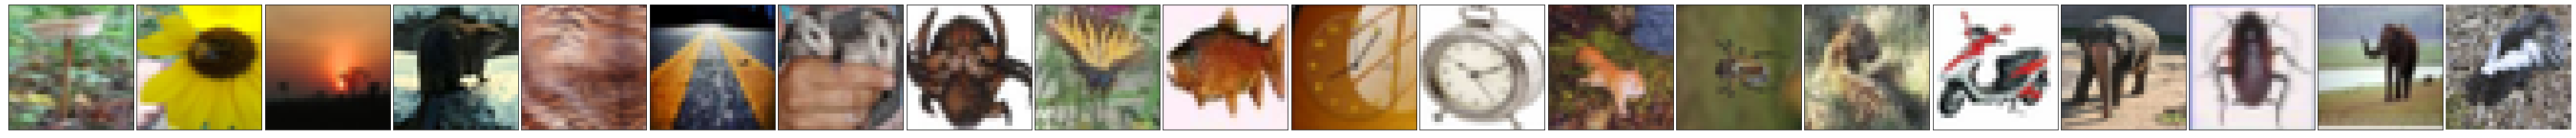

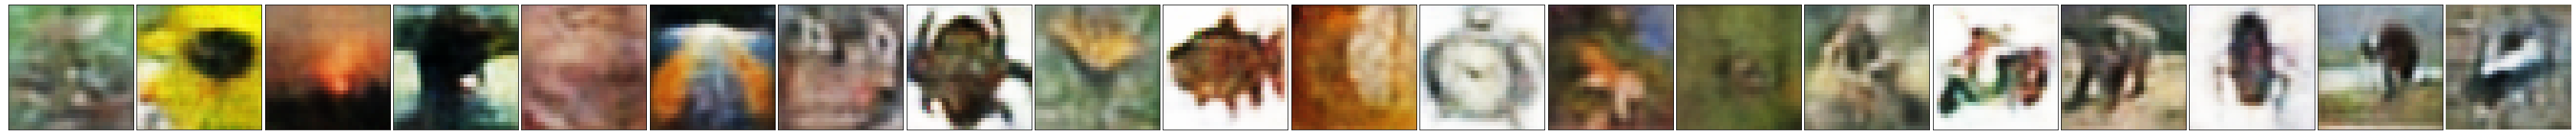

In [7]:
attacked_img = rec_x_private[15:35,:,:,:]
original_img = x_private[15:35,:,:,:]

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno');  
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
        
    return fig

fig = plot(original_img)
fig = plot(attacked_img)

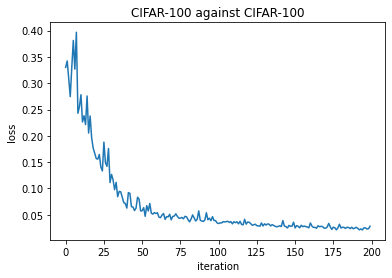

In [17]:
# plot the training loss:
log_freq = 10
sampled_log = [log[i*log_freq] for i in range(int(len(log)/log_freq))]
plt.title("CIFAR-100 against CIFAR-100")
plt.ylabel('loss')
plt.xlabel('iteration')
plt.plot(sampled_log)
# plt.plot(log_active[:,4])
# plt.plot(log_no_attack[:,0], color='green')
# plt.legend(['our attak', 'FSHA', 'no attack'], loc='upper right')
plt.show()

In [19]:
np.savetxt('./log/cifar100.csv', log, delimiter=',')

Seems all right!